It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/RNN/img2seq.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/RNN/img2seq.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

## Generate CAPTCHA Dataset

In [1]:
import string
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf
from IPython.display import Image, display

In [2]:
chars = set()
#chars.update(string.ascii_lowercase)
#chars.update(string.ascii_uppercase)
chars.update({str(i) for i in range(10)})
chars = sorted(chars)
print('Number of chars: {0}, chars: {1}'.format(len(chars), chars))

Number of chars: 10, chars: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [3]:
img_dir = './captcha/'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

In [4]:
#!pip install captcha

In [5]:
from captcha.image import ImageCaptcha
import uuid
create_dataset = True
captcha_len = 3
width = 40 + 20 * captcha_len
height = 100
n_images = 40000
if create_dataset:
    image = ImageCaptcha(width = width, height = height)
    print('Sample captcha str', np.random.choice(chars, captcha_len))
    seen = set()
    for _ in tqdm(range(n_images)):
        combi = np.random.choice(chars, captcha_len)
        captcha = ''.join(combi)
        image.write(captcha, '{0}{1}_{2}.png'.format(img_dir, captcha, uuid.uuid4()))

  0%|          | 0/40000 [00:00<?, ?it/s]

Sample captcha str ['3' '0' '8']


100%|██████████| 40000/40000 [06:23<00:00, 104.42it/s]


In [6]:
print('Number of captchas', len(os.listdir(img_dir)))
print('Some captchas', os.listdir(img_dir)[:5])

Number of captchas 40000
Some captchas ['243_7f499a79-c82e-4ed9-9f39-132b83c62989.png', '338_72252d2b-3d6a-4f3a-be12-c14901169b87.png', '169_776fbd43-23a7-4202-ad2f-285c2e7a6599.png', '772_57ece89a-81ad-48c4-beb7-bb909af396b6.png', '275_bf5d6e5d-7377-4716-aa11-65a289d91b71.png']


image shape:  (100, 100, 3)


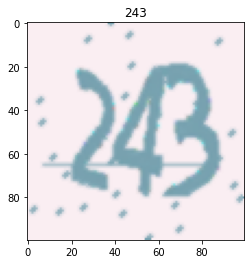

In [7]:
## Plot first sample
name = os.listdir(img_dir)[0]
x = tf.keras.preprocessing.image.load_img(os.path.join(img_dir, name))
x = tf.keras.preprocessing.image.img_to_array(x).astype(np.uint8)
print('image shape: ', x.shape)
plt.imshow(x)
plt.title(name.split('_')[0])
plt.show()

## Preprocessing data

Number of images found:  40000
Number of labels found:  40000
Number of unique characters:  10
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


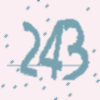

captcha: 243


In [8]:
data_dir = img_dir
# Get list of all the images
images, labels = zip(*[(os.path.join(img_dir, name), name.split('_')[0])
                       for name in os.listdir(img_dir)])
images, labels = (np.array(list(images)), np.array(list(labels)))
characters = sorted(set(char for label in labels for char in label))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)
display(Image(images[0]))
print('captcha:', labels[0])

### Characters processing
For converting the characters to one-hot encoding, we will use [tf.keras.layers.experimental.preprocessing.StringLookup
](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup). 
```python
tf.keras.layers.experimental.preprocessing.StringLookup(
    max_tokens=None, num_oov_indices=1, mask_token='',
    oov_token='[UNK]', vocabulary=None, encoding=None, invert=False,
    **kwargs
)
```

In [9]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


train_samples = int(0.7 * len(images))
val_split = int(0.8 * len(images))
x_train, y_train = images[:train_samples], labels[:train_samples]
x_val, y_val = images[train_samples:val_split], labels[train_samples:val_split]
x_test, y_test = images[val_split:], labels[val_split:]
print('x_train, y_train shape: ', x_train.shape, y_train.shape)

def encode_single_sample(img_path, label):
    
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    zeros = tf.zeros((captcha_len,1))
    return ((img, zeros), label)


x_train, y_train shape:  (28000,) (28000,)


### Generate Datasets

In [10]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(encode_single_sample)
train_dataset = train_dataset.batch(batch_size).cache().shuffle(50).prefetch(buffer_size=AUTOTUNE)
    
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(encode_single_sample)
validation_dataset = validation_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(encode_single_sample)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

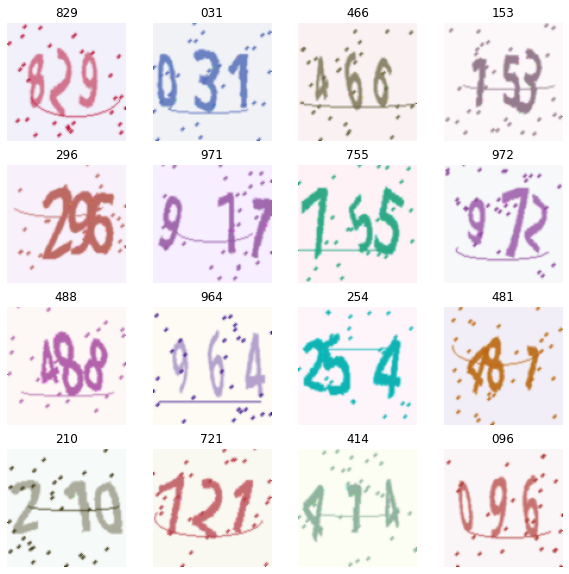

In [11]:
# plot samples
_, ax = plt.subplots(4, 4, figsize=(10, 10))
for (images_batch, zeros_batch), labels_batch in train_dataset.take(1):
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels_batch[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Questions 1: Create a model like a seq2seq
Study the impact of `encoder_vec_dim` on the performance of the model. 

In [31]:
encoder_vec_dim = 256  # dimension of the encoder vector

encoder_input = tf.keras.Input(shape=(width, height, 3),
                               name='encoder_input')

# First conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv1",
)(encoder_input)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)
x = layers.Dropout(0.3)(x)

# Second conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)

# Third conv block
x = layers.Conv2D(
    16,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="valid",
    name="Conv3",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool3")(x)


x = layers.Flatten()(x)
x = layers.Dense(encoder_vec_dim, activation='relu')(x)
encoded_vector = [x, x]



# Decoder
decoder_input = tf.keras.Input(shape=(captcha_len, 1),
                               name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(encoder_vec_dim, return_sequences=True,
                             name="decoder_1")(decoder_input,
                                             initial_state=encoded_vector)


decoder_output = layers.Dropout(0.25)(decoder_output)
output = layers.TimeDistributed(layers.Dense(len(characters)+1, activation='softmax'))(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 98, 98, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 49, 49, 16)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 49, 49, 16)   0           pool1[0][0]                      
____________________________________________________________________________________________

In [32]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [33]:
epochs = 100
early_stopping_patience = 5
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)

Epoch 1/100
219/219 [==============================] - 111s 500ms/step - loss: 2.3233 - accuracy: 0.1050 - val_loss: 2.0681 - val_accuracy: 0.2637
Epoch 2/100
219/219 [==============================] - 102s 464ms/step - loss: 1.7290 - accuracy: 0.3658 - val_loss: 0.7883 - val_accuracy: 0.7249
Epoch 3/100
219/219 [==============================] - 111s 506ms/step - loss: 0.6852 - accuracy: 0.7616 - val_loss: 0.3207 - val_accuracy: 0.8972
Epoch 4/100
219/219 [==============================] - 118s 539ms/step - loss: 0.3089 - accuracy: 0.8980 - val_loss: 0.1857 - val_accuracy: 0.9436
Epoch 5/100
219/219 [==============================] - 127s 582ms/step - loss: 0.1787 - accuracy: 0.9425 - val_loss: 0.1287 - val_accuracy: 0.9612
Epoch 6/100
219/219 [==============================] - 124s 563ms/step - loss: 0.1127 - accuracy: 0.9645 - val_loss: 0.1097 - val_accuracy: 0.9656
Epoch 7/100
219/219 [==============================] - 116s 530ms/step - loss: 0.0812 - accuracy: 0.9743 - val_loss: 0

KeyboardInterrupt: 

### Evaluate Test Results

In [34]:
results = model.evaluate(test_dataset, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

63/63 [==============================] - 12s 183ms/step - loss: 0.0658 - accuracy: 0.9801
Test Loss: 0.06583455204963684
Test Accuracy: 0.9801250100135803


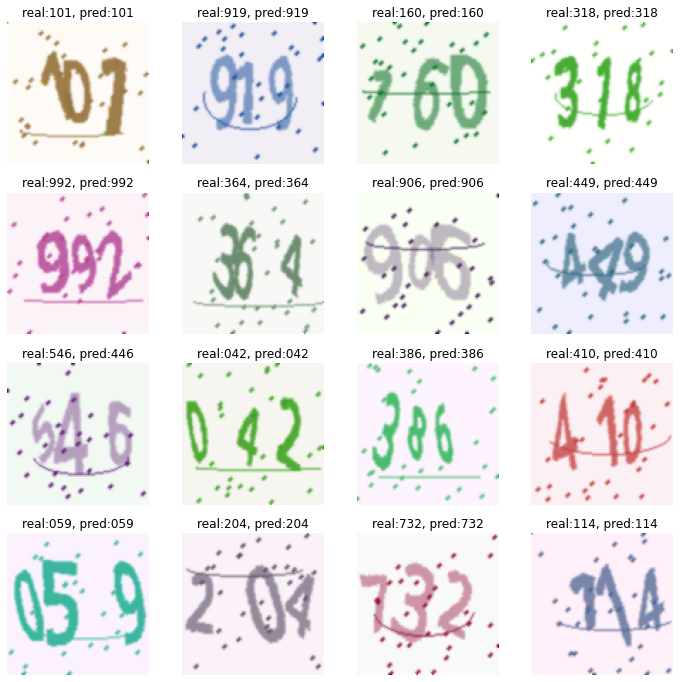

In [35]:
_, ax = plt.subplots(4, 4, figsize=(12, 12))
for (images_batch, zeros_batch), labels_batch in test_dataset.take(1):
    y_preds = model.predict([images_batch, zeros_batch]).argmax(-1)
    for i in range(16):
        img = (images_batch[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(
            labels_batch[i])).numpy().decode("utf-8")
        label_pred = tf.strings.reduce_join(num_to_char(
            y_preds[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4,
           i % 4].set_title('real:{0}, pred:{1}'.format(label, label_pred))
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
# pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False)
# pretrained_model.trainable = False

## Extra: Audio Captcha

In [ ]:
from IPython import display
aud_dir = './captcha_audio/'
if not os.path.exists(aud_dir):
    os.makedirs(aud_dir)

In [ ]:
from captcha.image import ImageCaptcha
from captcha.audio import AudioCaptcha

audio = AudioCaptcha()


In [ ]:
#!pip install wavio

In [ ]:
import uuid
import wavio
captcha_len = 3
n_audios = 50
audio = AudioCaptcha()
print('Sample captcha str', np.random.choice(chars, captcha_len))
seen = set()
for _ in tqdm(range(n_audios)):
    combi = np.random.choice(chars, captcha_len)
    captcha = ''.join(combi)
    captcha_path = '{0}{1}_{2}.wav'.format(aud_dir, captcha, uuid.uuid4())
    audio.write(captcha, captcha_path)
    
    wav = wavio.read(captcha_path).data
    # convert to 16-bits
    max_val = 2 ** 16 - 1 
    wav = (wav / 255.0 * max_val).astype(np.int16)
    wav_tf = tf.audio.encode_wav(
    wav, 8000, name=None
    )
    os. remove(captcha_path)
    tf.io.write_file(
    captcha_path, wav_tf, name=None
    )

In [ ]:
print('Number of captchas', len(os.listdir(aud_dir)))
print('Some captchas', os.listdir(aud_dir)[:5])

In [ ]:
file_path = os.path.join(aud_dir, os.listdir(aud_dir)[0]) 
audio_binary = tf.io.read_file(file_path)
audio, _ = tf.audio.decode_wav(audio_binary)
print(audio.shape)
waveform = tf.squeeze(audio, axis=-1)
print(waveform.shape)
print('captcha',os.listdir(aud_dir)[0].split('_')[0])
display.display(display.Audio(waveform, rate=8000))

In [ ]:
# Get list of all the images
audios, labels = zip(*[(os.path.join(aud_dir, name), name.split('_')[0])
                       for name in os.listdir(aud_dir)])
audios, labels = (np.array(list(audios)), np.array(list(labels)))
characters = sorted(set(char for label in labels for char in label))
print("Number of audios found: ", len(audios))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)


In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



train_samples = int(0.7 * len(audios))
val_split = int(0.8 * len(audios))
x_train, y_train = audios[:train_samples], labels[:train_samples]
x_val, y_val = audios[train_samples:val_split], labels[train_samples:val_split]
x_test, y_test = audios[val_split:], labels[val_split:]
print('x_train, y_train shape: ', x_train.shape, y_train.shape)

def encode_single_sample(aud_path, label):
    
    audio_binary = tf.io.read_file(aud_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)[:70000]
    
    zero_padding = tf.zeros([70000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the
    # same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    zeros = tf.zeros((captcha_len,1))
    return ((equal_length, zeros), label)


### Generate Datasets

In [ ]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(encode_single_sample)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(batch_size)
    
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(encode_single_sample)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(encode_single_sample)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

In [ ]:
for (audios_batch, zeros_batch), labels_batch in train_dataset.take(1):
    for i in range(4):
        label = tf.strings.reduce_join(num_to_char(labels_batch[i])).numpy().decode("utf-8")
        print('captcha',label)
        display.display(display.Audio(audios_batch[i], rate=8000))
